In [1]:
import ROOT
from array import array
import numpy as np
import scipy
import copy
import matplotlib.path as mpath
import matplotlib.pyplot as plt

Welcome to JupyROOT 6.22/06


Matplotlib created a temporary config/cache directory at /tmp/matplotlib-i0waws3e because the default path (/home/jovyan/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


# New plotting code

In [2]:
# Function to generate logarithmically spaced bins
def logspace_bins(start, stop, num):
    return np.logspace(np.log10(start), np.log10(stop), num)

In [3]:
def create_boundary_tgraph(boundary_exprs, n_points=1000,repl=["x","Q2"]):
    # Define the range of x and y values
    if(repl==["x","Q2"]):
        x_vals = np.linspace(0, 1, 1000)
        y_vals = np.linspace(0, 20, 1000)
    elif(repl==["z","pTtot"]):
        x_vals = np.linspace(-0.1, 1.1, 1000)
        y_vals = np.linspace(-0.1, 3, 1000)
    else:
        x_vals = np.linspace(0, 1, 1000)
        y_vals = np.linspace(0, 20, 1000)
    # Create a meshgrid from x and y values
    x, y = np.meshgrid(x_vals, y_vals)

    # Evaluate the inequalities for each point in the meshgrid
    ineq = np.ones_like(x, dtype=bool)
    for inequality in boundary_exprs:
        inequality=inequality.replace(repl[1],"y").replace(repl[0],"x")
        ineq = np.logical_and(ineq, eval(inequality))

    # Define the levels of the contour plot
    levels = [0.5, 1]

    # Create a contour plot of the inequalities
    contour_data= plt.contour(x, y, ineq, levels=levels, colors='k')
    # Hide the plot
    plt.close()
    xy_points = np.array(contour_data.collections[0].get_paths()[0].vertices)
    x=xy_points[:,0]
    y=xy_points[:,1]
    
    # Create the TGraph object
    graph = ROOT.TGraph(len(x), array('d', x), array('d', y))

    # Set the title and axis labels
    graph.SetTitle("My Graph")
    graph.GetXaxis().SetTitle("X Axis")
    graph.GetYaxis().SetTitle("Y Axis")
    graph.SetLineColor(1)
    graph.SetLineWidth(2)
    
    return graph

In [4]:
def generate_input_boundaries(x_bins, add_middle_cut):
    low_Q2_cut = "Q2>1.4144 + -5.4708 * x + 40.5357 * x*x + -40.0208 * x*x*x + 29.2121 * x*x*x*x"
    middle_Q2_cut="0.6361935324019532 + 5.961630973508846*x + 12.028695097029118*x*x"
    high_Q2_cut = "Q2<x*17"
    input_boundaries = []
    
    for i in range(len(x_bins)):
        x_min=x_bins[i][0]
        x_max=x_bins[i][1]
        input_boundary = [f"x<={x_max}", f"x>={x_min}"]
        if(add_middle_cut[i]==-1):
            input_boundary.append(f"Q2<{middle_Q2_cut}")
        elif(add_middle_cut[i]==1):
            input_boundary.append(f"Q2>{middle_Q2_cut}")
        input_boundary.append(high_Q2_cut)
        input_boundary.append(low_Q2_cut)
        input_boundaries.append(input_boundary)
        
    return input_boundaries

In [5]:
def create_tpave_text(i, btgraph,textsize):
    x_min = y_min = float('inf')
    x_max = y_max = float('-inf')

    x_center = 0
    y_center = 0

    N = btgraph.GetN()
    for j in range(N):
        x = btgraph.GetPointX(j)
        y = btgraph.GetPointY(j)

        x_min = min(x_min, x)
        x_max = max(x_max, x)
        y_min = min(y_min, y)
        y_max = max(y_max, y)

        x_center += x / N
        y_center += y / N

    tpave = ROOT.TPaveText(x_center - 0, y_center - 0, x_center + 0, y_center + 0)
    tpave.SetTextSize(textsize)
    tpave.AddText(str(i))
    tpave.SetTextColor(2)
    tpave.Draw("same")

    return copy.deepcopy(tpave)

In [6]:
def get_tgraph_boundaries(input_boundaries,repl=["x","Q2"]):
    btgraphs=[]
    for b in input_boundaries:
        btgraph = create_boundary_tgraph(b,1000,repl)
        btgraphs.append(btgraph)
    return copy.deepcopy(btgraphs)

In [7]:

def get_hists(infile,ttree,xQ2_boundaries, zpT_boundaries, var1, var2, var1_bins, var2_bins, var3, var3_bins, var4=None, var4_bins=None):

    # define cut conditions
    #cut_conditions = "xF1>0&&xF2>0&&z<0.95&&Mx>1.5"
    
    # create RDataFrame and select events that satisfy the cut conditions
    df = ROOT.RDataFrame(ttree, infile)
    df_cut = df.Filter(cut_conditions)
    df_cut=df
    
    # create main histogram
    main_hist = df_cut.Histo2D((f"h2d_main_{var1}_{var2}", f"{var1}-{var2} distribution", len(var1_bins) - 1, array('d', var1_bins), len(var2_bins) - 1, array('d', var2_bins)), var1,var2)
    
    var1_var2_hists = []
    var3_var4_hists = []
    var3_var4_subhists = []
    
    tmp_df_cuts=[]
    for idx, b in enumerate(xQ2_boundaries):
        print(idx + 1, "of", len(xQ2_boundaries))
        tmp_df_cut=df_cut.Filter("&&".join(b))
        tmp_df_cuts.append(tmp_df_cut)
        
        # create histogram for var1 and var2
        h2d_var1_var2 = tmp_df_cuts[-1].Histo2D((f"h2d_{var1}_{var2}_{idx}", f"{var1}-{var2} distribution", len(var1_bins) - 1, array('d', var1_bins), len(var2_bins) - 1, array('d', var2_bins)), var1,var2)
        
        var1_var2_hists.append(h2d_var1_var2)

        h2d_var3_var4 = tmp_df_cuts[-1].Histo2D((f"h2d_{var3}_{var4}_{idx}", f"{var3}-{var4} distribution", len(var3_bins) - 1, array('d', var3_bins), len(var4_bins) - 1, array('d', var4_bins)), var3,var4)
            
        var3_var4_hists.append(h2d_var3_var4)
        
        var3_var4_subhists_arr=[]
        
        for idxidx,bb in enumerate(zpT_boundaries):
            tmptmp_df_cut = tmp_df_cut.Filter("&&".join(bb))
            tmp_df_cuts.append(tmptmp_df_cut)
            h2d_var3_var4_sub = tmp_df_cuts[-1].Histo2D((f"h2d_{var3}_{var4}_{idx}_sub", f"{var3}-{var4} distribution", len(var3_bins) - 1, array('d', var3_bins), len(var4_bins) - 1, array('d', var4_bins)), var3,var4)
            var3_var4_subhists_arr.append(h2d_var3_var4_sub)
    
        var3_var4_subhists.append(var3_var4_subhists_arr)
        
    # force z-axis to be identical to main hist
    zmin = main_hist.GetMinimum()
    zmax = main_hist.GetMaximum()
    
    for h in var1_var2_hists:
        h.SetMinimum(zmin)
        h.SetMaximum(zmax)
    
    return main_hist.GetValue(), [h.GetValue() for h in var1_var2_hists], [h.GetValue() for h in var3_var4_hists], [[h.GetValue() for h in hlist] for hlist in var3_var4_subhists]


In [8]:
def generate_z_pt_boundaries(z_edges, pT_edges):
    boundaries = []
    nzbins = len(z_edges) - 1
    npTbins = len(pT_edges) - 1

    for iz in range(nzbins):
        for ip in range(npTbins):
            boundaries.append([f"z>={z_edges[iz]}", f"z<{z_edges[iz+1]}", f"pTtot>={pT_edges[ip]}", f"pTtot<{pT_edges[ip+1]}"])

    return boundaries

In [9]:
def create_info_box(histogram):
    # get number of entries and average x and y values
    n_entries = histogram.GetEntries()
    mean_x = histogram.GetMean(1)
    mean_y = histogram.GetMean(2)

    # create TPaveText object
    text_box = ROOT.TPaveText(0.16, 0.625, 0.5, 0.85, "NDC")  # x1, y1, x2, y2
    text_box.SetTextSize(0.04)
    text_box.SetTextAlign(11)  # set text alignment to left-justified
    text_box.SetTextFont(42)  # set font to normal weight
    #text_box.SetFillColor(ROOT.kWhite)
    #text_box.SetBorderSize(0)

    # add text with information
    text_box.AddText(f"Evts: {n_entries:.2e}")
    text_box.AddText(f"<x>: {mean_x:.3f}")
    text_box.AddText(f"<Q^{{2}}>: {mean_y:.3f} [GeV^{{2}}]")

    return copy.deepcopy(text_box)

In [10]:
def gen_canvas(xQ2_boundaries=[], zpT_boundaries=[], boundary_idx=None, h_xQ2=None, h_xQ2_list=None, h_zpT_list=None, h_zpT_sublist=None):

    xQ2_tgraphs = get_tgraph_boundaries(xQ2_boundaries,["x","Q2"])
    zpT_tgraphs = get_tgraph_boundaries(zpT_boundaries,["z","pTtot"])
    
    # Create a canvas and divide it into two pads for x-Q2 and z-pT histograms
    c = ROOT.TCanvas("c", "x-Q2 distribution", 1200, 600)
    c.Divide(2, 1)

    # Prepare x-Q2 histogram for selected region with log scale axes
    c.cd(1)
    ROOT.gPad.SetLogx()
    ROOT.gPad.SetLogy()
    ROOT.gPad.SetRightMargin(0.15)
    h2d_xQ2 = h_xQ2_list[boundary_idx]
    prepare_hist(h2d_xQ2, ";x;Q^{2} [GeV]", 50)
    h2d_xQ2.Draw("colz")
    text_box = create_info_box(h2d_xQ2)
    text_box.Draw()
    # Draw boundaries on x-Q2 histogram
    for xQ2_tgraph in xQ2_tgraphs:
        xQ2_tgraph.Draw("L same")

    # Create z-pT histogram for selected region
    h2d_zpT = h_zpT_list[boundary_idx]
    h2d_zpT_sublist = h_zpT_sublist[boundary_idx]
    
    # Prepare z-pT histogram with log scale axes
    c.cd(2)
    ROOT.gPad.SetRightMargin(0.15)
    prepare_hist(h2d_zpT, "z pT distribution;z;p_{T} [GeV]", 50)
    h2d_zpT.Draw("colz")
    
    # Draw boundaries on z-pT histogram
    tpaves_zpT = []
    for i,zpT_tgraph in enumerate(zpT_tgraphs):
        zpT_tgraph.Draw("L same")
        entries=h2d_zpT_sublist[i].GetEntries()
        tpaves_zpT.append(create_tpave_text(str(f"{entries:.0e}"), zpT_tgraph,0.04))
        #tpaves_zpT[-1].Draw("same")
        
    # Draw the x-Q2 histogram with all boundaries shown
    c2 = ROOT.TCanvas("c2", "c2", 600, 600)
    ROOT.gPad.SetLogx()
    ROOT.gPad.SetLogy()

    h2d_xQ2_all = h_xQ2
    prepare_hist(h2d_xQ2_all, ";x;Q^{2} [GeV]", 50)
    h2d_xQ2_all.Draw("colz")
    
    # Draw boundaries and add labels on x-Q2 histogram
    tpaves_xQ2 = []
    for i,xQ2_tgraph in enumerate(xQ2_tgraphs):
        xQ2_tgraph.Draw("L same")
        tpaves_xQ2.append(create_tpave_text(i, xQ2_tgraph,0.08))
        tpaves_xQ2[-1].Draw("same")

    c.SaveAs(f"4d_plots/c_xQ2bin_{boundary_idx}.pdf")
    return copy.deepcopy(c), copy.deepcopy(c2)


def prepare_hist(hist, title, num_contours):
    """Prepare histogram with specified title, number of contours, and without stats."""
    hist.SetTitle(title)
    hist.SetContour(num_contours)
    hist.SetStats(0)


In [11]:
# Define the boundary expressions

x_arr = [[0.07,0.12],[0.12,0.2],[0.2,0.275],[0.275,0.42],[0.42,1], [0.12,0.15],[0.15,0.22],[0.22,0.29],[0.29,0.42]]
Q2_arr = [0,-1,-1,-1,0,1,1,1,1] # Same length as x arr. 0 --> dont use center line, -1 below center line, +1 above center line

z_arr = [0.3,0.38,0.5,0.6,0.7,0.9]
pT_arr = [0,0.2,0.4,0.6,0.8,1,1.5]

xQ2_boundaries = generate_input_boundaries(x_arr, Q2_arr)
zpT_boundaries = generate_z_pt_boundaries(z_arr,pT_arr)

In [12]:
# Example usage
x_bins = logspace_bins(5e-2, 1, 100)
Q2_bins = logspace_bins(1, 20, 100)
z_bins = np.linspace(0, 1, 100)
pt_bins = np.linspace(-0.3, 2, 100)

infile = "../../projects/ana_v1/volatile/data/piplus_piminus/MC_RGA_3051_0.root"
ttree  = "dihadron_cuts"

#infile = "../../macros/hipoLUND2tree.root"
#ttree  = "dihadron"

xQ2_hist_main, xQ2_hists, zpT_hists, zpT_subhists = get_hists(infile, ttree, xQ2_boundaries, zpT_boundaries,"x", "Q2", x_bins, Q2_bins, "z", z_bins, "pTtot", pt_bins)

1 of 9
2 of 9
3 of 9
4 of 9
5 of 9
6 of 9
7 of 9
8 of 9
9 of 9


In [40]:
for i in range(len(xQ2_boundaries)):
    c1,c2=gen_canvas(xQ2_boundaries, zpT_boundaries, i,xQ2_hist_main, xQ2_hists, zpT_hists, zpT_subhists)

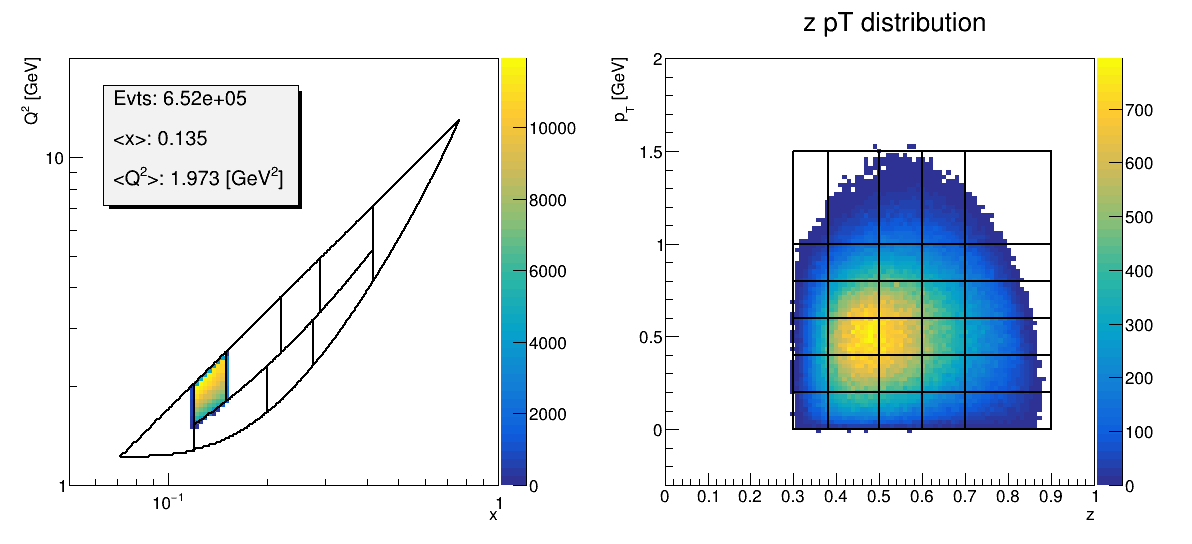

In [41]:
c1,c2=gen_canvas(xQ2_boundaries, zpT_boundaries, 5,xQ2_hist_main, xQ2_hists, zpT_hists, zpT_subhists)
c1.Draw()

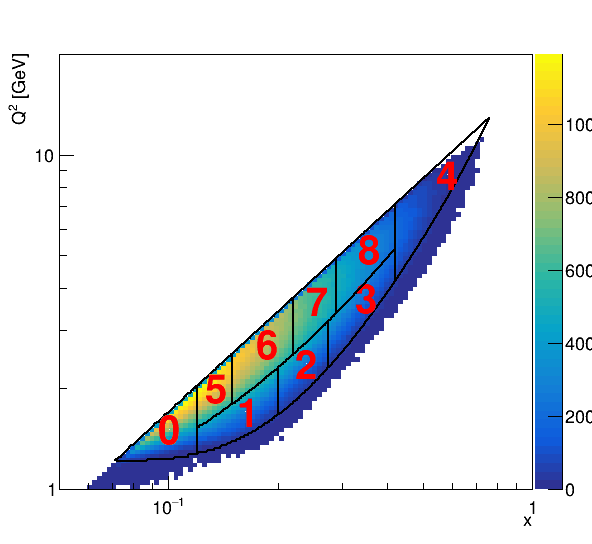

In [42]:
c2.Draw()

In [43]:
import os
import re
from pathlib import Path

dir = "/work/clas12/users/gmat/clas12/clas12_dihadrons/plotting/misc_ana_code/4d_plots"  # Directory where the files are located
prefix="c_xQ2bin"

# Search for files with the specified pattern
pattern = re.compile(prefix+r"_(.+?)\.pdf")
files = [f for f in os.listdir(dir) if re.match(pattern, f)]
files=sorted(files)
# Generate LaTeX file
latex_file = f"{dir}/xQ2.tex"
with open(latex_file, "w") as f:
    f.write("\\documentclass{article}\n")
    f.write("\\usepackage{graphicx}\n")
    f.write("\\usepackage{geometry}\n")
    f.write("\\usepackage{fancyhdr}\n")
    f.write("\\geometry{margin=1cm}\n") # Set the margin to 1 cm
    f.write("\\usepackage{subcaption}\n")
    f.write("\\usepackage[font=large]{caption}\n") # Set the caption font size to large
    f.write("\\begin{document}\n")
    f.write("\\pagestyle{fancy}\n")
    f.write("\\fancyhf{}\n")
    f.write("\\fancyhead[L]{\\leftmark\\,\\,\\,\\,\\rightmark}\n")
    f.write("\\fancyhead[R]{\\thepage}\n")
    for ifile,file in enumerate(files):
        #CHANNEL = channel.replace("piplus", "$\\pi^{+}$").replace("piminus", "$\\pi^{-}$").replace("pi0", "$\\pi^{0}$").replace("_", "")
        f.write("\\begin{figure}[ht]\n")
        f.write("\\centering\n")
        f.write(f"\\includegraphics[width=0.95\\textwidth]{{{Path(dir) / file}}}\n")
        f.write(f"\\caption{{x-Q2 bin {ifile}}}\n")
        f.write("\\end{figure}\n")

    f.write("\\end{document}\n")

print(f"LaTeX file '{latex_file}' has been generated.")

LaTeX file '/work/clas12/users/gmat/clas12/clas12_dihadrons/plotting/misc_ana_code/4d_plots/xQ2.tex' has been generated.


In [44]:
# Get the directory part of the LaTeX filename
latex_dirname = "./4d_plots/"

# Save the current working directory
cwd = os.getcwd()

# Change the current working directory to the LaTeX directory
os.chdir(latex_dirname)

# Compile the LaTeX file into a PDF
os.system(f"pdflatex {latex_file}")
os.system(f"pdflatex {latex_file}")

# Change the current working directory back to the original
os.chdir(cwd)

This is pdfTeX, Version 3.14159265-2.6-1.40.20 (TeX Live 2019/Debian) (preloaded format=pdflatex)
 restricted \write18 enabled.
entering extended mode

(/work/clas12/users/gmat/clas12/clas12_dihadrons/plotting/misc_ana_code/4d_plot
s/xQ2.tex
LaTeX2e <2020-02-02> patch level 2
L3 programming layer <2020-02-14>
(/usr/share/texlive/texmf-dist/tex/latex/base/article.cls
Document Class: article 2019/12/20 v1.4l Standard LaTeX document class
(/usr/share/texlive/texmf-dist/tex/latex/base/size10.clo))
(/usr/share/texlive/texmf-dist/tex/latex/graphics/graphicx.sty
(/usr/share/texlive/texmf-dist/tex/latex/graphics/keyval.sty)
(/usr/share/texlive/texmf-dist/tex/latex/graphics/graphics.sty
(/usr/share/texlive/texmf-dist/tex/latex/graphics/trig.sty)
(/usr/share/texlive/texmf-dist/tex/latex/graphics-cfg/graphics.cfg)
(/usr/share/texlive/texmf-dist/tex/latex/graphics-def/pdftex.def)))
(/usr/share/texlive/texmf-dist/tex/latex/geometry/geometry.sty
(/usr/share/texlive/texmf-dist/tex/generic/iftex/ifvte

In [45]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [2]:
def polynomial(x, *coeffs):
    """
    Helper function to evaluate a polynomial of arbitrary degree at x
    """
    return sum([c * x**i for i, c in enumerate(coeffs)])

def plot_ymin_vs_x(hist, m):
    nbins_x = hist.GetNbinsX()
    ymin = []
    bin_centers_x = []
    for i in range(1, nbins_x+1):
        bin_center_x = hist.GetXaxis().GetBinCenter(i)
        y_vals = [hist.GetBinContent(i,j) for j in range(1, hist.GetNbinsY()+1)]
        non_zero_y_vals = [y for y in y_vals if y != 0]
        if len(non_zero_y_vals) > 0:
            index_min_y = np.argmin(non_zero_y_vals)
            ymin.append(hist.GetYaxis().GetBinCenter(y_vals.index(non_zero_y_vals[index_min_y])+1))
            bin_centers_x.append(bin_center_x)
    bin_centers_x = np.array(bin_centers_x)
    ymin = np.array(ymin)
    
    # Use curve_fit to fit the data to a polynomial
    popt, pcov = curve_fit(polynomial, bin_centers_x, ymin, p0=np.ones(m+1))
    xp = np.linspace(bin_centers_x[0], bin_centers_x[-1], 100)
    yp = polynomial(xp, *popt)
    
    # Print the fit parameters as a copy-able function
    fit_func = ' + '.join([f'{c:.4f} * x**{i}' for i, c in enumerate(popt)])
    print(f'Polynomial fit parameters: {fit_func}')
    
    # Plot the data and the polynomial fit
    plt.plot(bin_centers_x, ymin, 'bo', label='Data')
    plt.plot(xp, yp, 'r-', label=f'{m} degree polynomial fit')
    plt.xlabel("x")
    plt.ylabel("Minimum y value")
    plt.legend()
    plt.show()

Polynomial fit parameters: 1.4144 * x**0 + -5.4708 * x**1 + 40.5357 * x**2 + -40.0208 * x**3 + 29.2121 * x**4


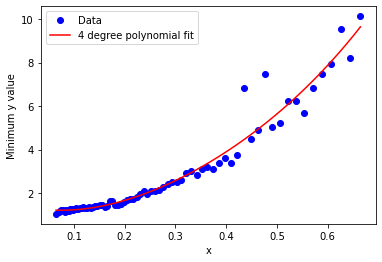

In [18]:
plot_ymin_vs_x(xQ2_hist_main,4)

In [88]:
def create_nested_dict(x_arr, z_arr, pT_arr, xQ2_hists, zpT_subhists):
    # Initialize an empty dictionary to store the nested counts
    nested_dict = {}

    # Loop over each value in x_arr
    for i in range(len(x_arr)):
        # Initialize an empty dictionary for this value of i
        name_i = f"x_Q2_bin_{i}"
        x = np.round(xQ2_hists[i].GetMean(1),4)
        Q2 = np.round(xQ2_hists[i].GetMean(2),4)
        
        nested_dict[name_i] = {"x":x,"Q2":Q2}

        # Loop over each value in z_arr, except for the last value
        for j in range(len(z_arr)-1):
            # Initialize an empty dictionary for this value of j
            name_j = f"z_bin_{j}"
            z = z_arr[j]
            nested_dict[name_i][name_j] = {"z":z}

            # Loop over each value in pT_arr, except for the last value
            for k in range(len(pT_arr)-1):
                # Initialize an empty dictionary for this value of k
                name_k = f"pT_bin_{k}"
                pT = np.round((pT_arr[k] + pT_arr[k+1])/2,3)

                # Calculate the bin number for this (z,pT) pair
                zpT_binnum = j*(len(pT_arr)-1)+k

                # Get the number of counts for this (z,pT) pair
                counts = zpT_subhists[i][zpT_binnum].GetEntries()

                # Store the counts and pT value in the nested dictionary
                nested_dict[name_i][name_j][name_k] = {"Counts":counts,"pT":pT}

    # Return the completed nested dictionary
    return nested_dict

In [89]:
my_nested_dict = create_nested_dict(x_arr, z_arr, pT_arr, xQ2_hists,  zpT_subhists)

In [90]:
my_nested_dict

{'x_Q2_bin_0': {'x': 0.1008,
  'Q2': 1.4419,
  'z_bin_0': {'z': 0.3,
   'pT_bin_0': {'Counts': 70083.0, 'pT': 0.1},
   'pT_bin_1': {'Counts': 151436.0, 'pT': 0.3},
   'pT_bin_2': {'Counts': 129487.0, 'pT': 0.5},
   'pT_bin_3': {'Counts': 66001.0, 'pT': 0.7},
   'pT_bin_4': {'Counts': 21548.0, 'pT': 0.9},
   'pT_bin_5': {'Counts': 5184.0, 'pT': 1.25}},
  'z_bin_1': {'z': 0.38,
   'pT_bin_0': {'Counts': 66405.0, 'pT': 0.1},
   'pT_bin_1': {'Counts': 146364.0, 'pT': 0.3},
   'pT_bin_2': {'Counts': 131857.0, 'pT': 0.5},
   'pT_bin_3': {'Counts': 72582.0, 'pT': 0.7},
   'pT_bin_4': {'Counts': 26451.0, 'pT': 0.9},
   'pT_bin_5': {'Counts': 7266.0, 'pT': 1.25}},
  'z_bin_2': {'z': 0.5,
   'pT_bin_0': {'Counts': 31643.0, 'pT': 0.1},
   'pT_bin_1': {'Counts': 71573.0, 'pT': 0.3},
   'pT_bin_2': {'Counts': 67194.0, 'pT': 0.5},
   'pT_bin_3': {'Counts': 39386.0, 'pT': 0.7},
   'pT_bin_4': {'Counts': 15549.0, 'pT': 0.9},
   'pT_bin_5': {'Counts': 4928.0, 'pT': 1.25}},
  'z_bin_3': {'z': 0.6,
   'p